# Wide and Deep Networks

Nick Chao

### Preparation (40 points total)
[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). 

[10 points] Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 

[10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### Modeling (50 points total)
[20 points] Create several combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Try to use the "history" return parameter that is part of Keras "fit" function.

[20 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab. 

[10 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve.  Use proper statistical method to compare the performance of different models.  

### Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea (required for 7000 level students): Capture the embedding weights from the deep network and perform t-SNE clustering on the output of these embedding layers. That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform clustering of these output embeddings. Visualize and explain the results.

## Preparation

For my dataset, I chose to use the dataset I've been using for the last two labs which is the 2009 American Community Survey. The goal of this dataset is to determine whether or not a person has an income greater than 100,000 dollars based on qualities about them such as sex, age, race, place of work, etc. This dataset starts with over 3 million entrees and almost 300 attributes which will eventually be narrowed down to 1.3 million entrees and 13 attributes.


|Attribute|Description|Type|Example|
|:---:|:---:|:---:|:---:|
| CIT | Citizenship Status | Int | 1. Citizen, 0. Non-citizen |
| AGEP | Age | Int | 23
| COW | Class of Worker | Float | 3. Local Government, 4. State Government |
| ENG | Ability to speak English  | Int | 1. Speaks English, 0. Doesn't Speak English |
| MAR | Marital Status | Int | 1. Married, 2. Widowed |
| MIL | Military Service | Int | 1. Yes, 0. No |
| SCHL | Educational Attainment  | Float | 21 Bachelor's Degree, 22 Master's Degree |
| SEX | Sex      | Int | True. Male |
| DIS | Disability | Int | True. Disabled |
| PINCP | Total Person's Income | Float
| POWSP | Place of work | Float | 048 Texas, 049 Utah |
| RAC1P | Detailed Race Code | Int | 1 White, 6 Asian |
| FOD1P | Field of Degree | Float | 2407 Computer Engineering, 2408 Electrical Engineering |

The reamining features we keep as they are attributes that are likely related to one's personal income

### Preprocessing

In [43]:
# #importing dependancies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.models import Model

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from copy import deepcopy

# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold, ShuffleSplit
# from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
# from sklearn.linear_model import LogisticRegression
# from sklearn.utils.estimator_checks import check_estimator
# from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
# from sklearn.metrics import make_scorer
# from sklearn.metrics import precision_score, recall_score


import warnings
warnings.filterwarnings('ignore')

In [2]:
%time dataA = pd.read_csv('../data/ss09pusa.csv')
%time dataB = pd.read_csv('../data/ss09pusb.csv')
merged = pd.concat([dataA,dataB])

CPU times: user 35.5 s, sys: 2.87 s, total: 38.3 s
Wall time: 38.4 s
CPU times: user 34.2 s, sys: 1.69 s, total: 35.9 s
Wall time: 35.9 s


In [3]:
cols_to_save = ['CIT','AGEP','COW','ENG','MAR','MIL','SCHL','SEX','DIS','PINCP','POWSP','RAC1P','FOD1P']
new_data = merged.filter(items=cols_to_save)
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3030728 entries, 0 to 1466654
Data columns (total 13 columns):
CIT      int64
AGEP     int64
COW      float64
ENG      float64
MAR      int64
MIL      float64
SCHL     float64
SEX      int64
DIS      int64
PINCP    float64
POWSP    float64
RAC1P    int64
FOD1P    float64
dtypes: float64(7), int64(6)
memory usage: 323.7 MB


In [4]:
# Change citizenship to Int.
# 1-4 is a citizen (true) and 5 is not a citizen (false)

new_data.CIT.replace(to_replace = range(5),
                    value=[1,1,1,1,0],
                    inplace=True)
new_data['CIT'] = new_data['CIT'].astype('bool')


# Change Ability to Speak English to boolean
# b is N/A but it would be a good assumption to assume they speak English
new_data['ENG']=new_data['ENG'].fillna(1)
# 1-2 speaks English well or very well, 3-4 speaks English not well or not at all.
new_data.ENG.replace(to_replace = range(4),
                    value=[1,1,0,0],
                    inplace=True)
new_data['ENG'] = new_data['ENG'].astype('int')


# Change Military Status to Boolean
# b is N/A because less than 17 years old so lets just change this to 0
new_data['MIL']=new_data['MIL'].fillna(0)
# 1-3 Yes, 4-5 No
new_data.MIL.replace(to_replace = range(5),
                    value=[1,1,1,0,0],
                    inplace=True)
new_data['MIL'] = new_data['MIL'].astype('bool')


# Change Sex to bool
# 1 is male, 2 is female. Changing 2 to 0 for boolean conversion
new_data.SEX.replace(to_replace = range(2),
                    value=[1,0],
                    inplace=True)
new_data['SEX'] = new_data['SEX'].astype('bool')


# Change DIS to bool
# 1 is disabled, 2 is no disability. Changing 2 to 0 for boolean conversion
new_data.DIS.replace(to_replace = range(2),
                    value=[1,0],
                    inplace=True)
new_data['DIS'] = new_data['DIS'].astype('bool')


# Change Educational Atttainment to INT
# bb is N/A for less than 3 years old.
new_data['SCHL']=new_data['SCHL'].fillna(0)
# For this classification lets simplify some of these education levels.
# 0 between No schooling and Grade 8
# 1 between Grade 9 and Grade 12 no diploma
# 2 for High School degree or GED
# 3 Some college to Associate's degree
# 4 Bachelor's Degree
# 5 Master's Degree
# 6 Professional degree or Doctorate
# new_data.SCHL.replace(to_replace = range(25),
#                     value=[0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,2,2,3,3,3,4,5,6,6],
#                     inplace=True)
new_data['SCHL'] = new_data['SCHL'].astype('int')


In [5]:
# delete younger than 18
new_data = new_data[new_data.AGEP >= 18]
#new_data

# Field of Study  -> 0
# Class of Worker -> Remove if Null
# Place of Work   -> Remove if Null

new_data['FOD1P'].fillna(0, inplace=True)
new_data = new_data[pd.notnull(new_data['COW'])]
new_data = new_data[pd.notnull(new_data['POWSP'])]

# Convert the Floats to Ints
# COW, POWSP, FOD1P, PINCP

new_data['COW'] = new_data['COW'].astype('int')
new_data['POWSP'] = new_data['POWSP'].astype('int')
new_data['FOD1P'] = new_data['FOD1P'].astype('int') # field of study
new_data['PINCP'] = new_data['PINCP'].astype('int')

future_data = new_data.copy(deep=False) # saving a copy for later

In [6]:
# Converting income to bool of either greater than or less than 100,000 income

mask_0 = new_data.PINCP <= 99999
column_name = 'PINCP'
new_data.loc[mask_0, column_name] = 0

mask_1 = new_data.PINCP > 99999
column_name = 'PINCP'
new_data.loc[mask_1, column_name] = 1
new_data['PINCP'] = new_data['PINCP'].astype('bool')


In [7]:
# Lets see how the income classes have split...
print('Number of people in each class:')
for value in new_data.PINCP.unique(): 
    print(str(value)+': ' +str(len(new_data[new_data['PINCP'] == value])))

Number of people in each class:
False: 1209410
True: 128869


In [8]:
# Finally, let's rename some of these columns so they make more sense.
new_data.rename(columns={'CIT': 'Citizenship','AGEP': 'Age','COW': 'Class_of_Work','ENG': 'Speaks_English',
                         'MAR': 'Martial_Status','MIL': 'Military_Status','SCHL': 'Education_Level','SEX': 'Male',
                         'DIS': 'Disabled','PINCP': 'Income','POWSP': 'Place_of_Work','RAC1P': 'Race','FOD1P': 'Field_of_Study'}
                , inplace=True)
new_data.info()
new_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338279 entries, 1 to 1466654
Data columns (total 13 columns):
Citizenship        1338279 non-null bool
Age                1338279 non-null int64
Class_of_Work      1338279 non-null int64
Speaks_English     1338279 non-null int64
Martial_Status     1338279 non-null int64
Military_Status    1338279 non-null bool
Education_Level    1338279 non-null int64
Male               1338279 non-null bool
Disabled           1338279 non-null bool
Income             1338279 non-null bool
Place_of_Work      1338279 non-null int64
Race               1338279 non-null int64
Field_of_Study     1338279 non-null int64
dtypes: bool(5), int64(8)
memory usage: 98.3 MB


,Citizenship,Age,Class_of_Work,Speaks_English,Martial_Status,Military_Status,Education_Level,Male,Disabled,Income,Place_of_Work,Race,Field_of_Study
1,True,64,1,1,1,True,19,True,False,False,1,1,0
2,True,68,1,1,1,False,14,False,False,False,1,1,0
3,True,61,1,1,3,True,16,True,True,False,1,2,0
4,True,38,1,1,5,True,16,False,True,False,1,2,0
6,True,74,1,1,1,False,16,False,False,False,1,1,0


## Crossing Features

In [9]:
# Since this dataset is generally all numeric data, we don't need to concern ourselves with object data
df_features = ['Citizenship', 'Age', 'Class_of_Work', 'Speaks_English', 'Martial_Status', 'Military_Status', 
               'Education_Level', 'Male', 'Disabled', 'Place_of_Work', 'Race', 'Field_of_Study']

df_class = ['Income']

X = new_data[df_features]
y = new_data[df_class]

In [10]:
encodersencoder  = dict() 
categorical_headers_ints = ['Speaks_English','Class_of_Work','Martial_Status','Place_of_Work','Race', 'Field_of_Study']

categorical_headers_bools = ['Citizenship','Disabled','Military_Status','Male']


# scale the numeric, continuous variables
numeric_headers = ["Age", "Education_Level"]

Here we add some cross columns on strongly correlated data.
Lets start by plotting the correlation mattrix 

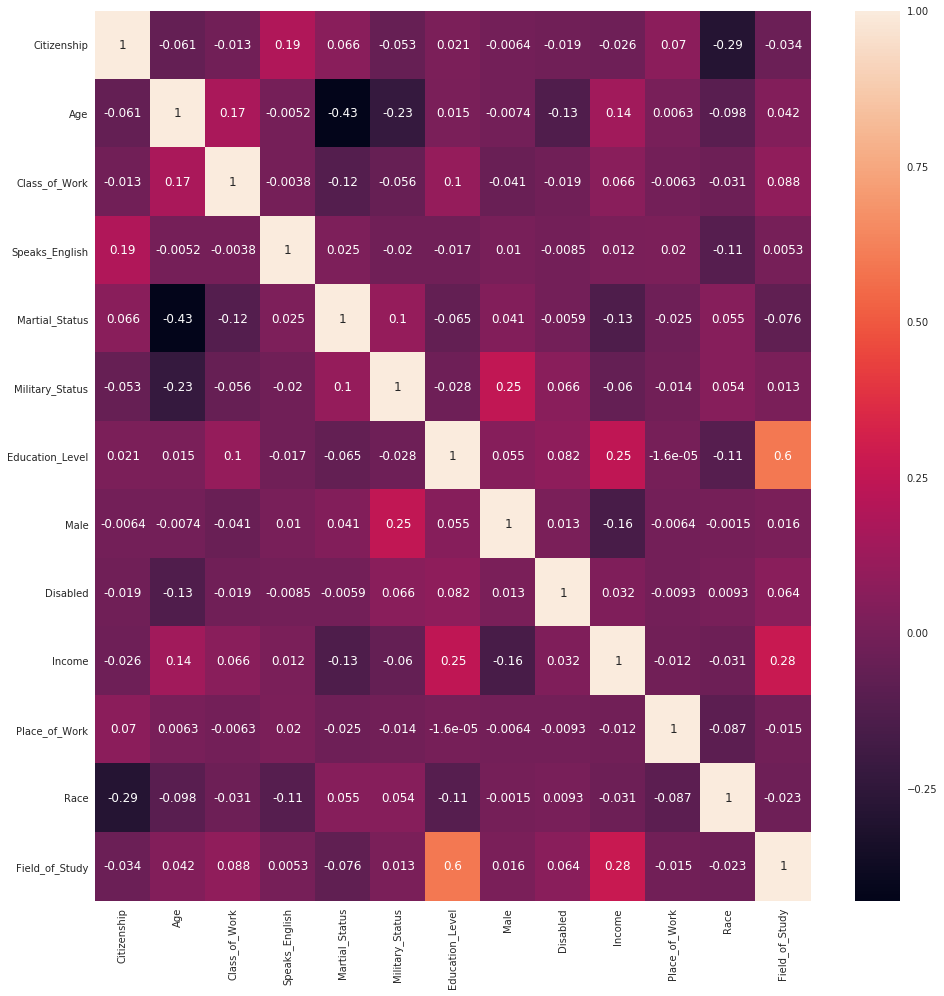

In [11]:
cmap = sns.set(style="darkgrid")

f, ax = plt.subplots(figsize=(14,14))
sns.heatmap(new_data.corr(), cmap=cmap, annot=True)
f.tight_layout()

Since Education level and Field of Study are the only attributes that are even slightly correlated, those are the features I will cross. I will also cross English and Citizenship since those who are Citizens usually speak English.

### Evaluation

Goal: Determine if a person's income is above $100,000.

Since my chosen task is a binary classification task, we need to determine what type of evaluation metric works best for this case. We can start by establishing a business case. Let's say an advertising agency is attemping to solve this problem to determine what type of ads should be targeted towards a person based on their income. For example, cheaper products for people of lower income and expensive products for people of higher income. Targeting viewers with the wrong type of ads would not only be pointless, but costly as it is unlikely consumers would purchase the advertised product. 

In this case, we would want high recall and precision. A good recall would be the ability for the model to identify all person's will incomes above 100,000 and mark them as so. A high precision  is the ability for the model to be correct when it claims a person's income is above 100,000. Utilizing F-Score will allow us to evaluate the model using both recall and precision.

### Training and Testing

With regards to splitting the data for training and testing purposes, I am going to split the data into 80% for training and 20% for testing, ensuring that both sets are equally portional. Since my data set is very large I should not have a problem being able to do this and cross validation should not be neccessary as there is over a million entres.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# This returns a tensor
inputs = Input(shape=(X_train.shape[1],))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(units=10, activation='relu')(inputs)
predictions = Dense(1,activation='sigmoid')(x)

# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=predictions)

In [13]:
# Double checking to ensure that the split is evenly proportion
print('Number of people in each class:')
for value in new_data.Income.unique(): 
    print(str(value)+': ' +str(len(new_data[new_data['Income'] == value])))
    
print('Number of people in each class:')
for value in y_train.Income.unique(): 
    print(str(value)+': ' +str(len(y_train[y_train['Income'] == value])))
    
print('Number of people in each class:')
for value in y_test.Income.unique(): 
    print(str(value)+': ' +str(len(y_test[y_test['Income'] == value])))

Number of people in each class:
False: 1209410
True: 128869
Number of people in each class:
True: 103126
False: 967497
Number of people in each class:
False: 241913
True: 25743


## Modeling

In [14]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time

model.fit(X_train, y_train, epochs=10, batch_size=50, verbose=0)

from sklearn import metrics as mt
yhat = np.round(model.predict(X_test))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[241913      0]
 [ 25743      0]] 0.9038205756642855
CPU times: user 6min 53s, sys: 50.2 s, total: 7min 43s
Wall time: 4min 5s


Using only MLP with one hidden layer we get a decent confusion matrix of 72% accuracy.

### OHE Model

In [16]:
# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train[df_features].values)
X_test_ohe = ohe.transform(X_test[df_features].values)

# the ohe instance will help us to organize our encoded matrix
print(ohe.feature_indices_)
print(X_train_ohe.shape)

[   0    2   98  107  112  118  120  145  147  149  705  715 7119]
(1070623, 366)


In [17]:
# combine the features with two branches

# and save off the numeric features
X_train_num =  X_train[numeric_headers].values
X_test_num = X_test[numeric_headers].values

# create sparse input branch for ohe
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
xSparse = Dense(units=10, activation='relu', name='ohe_1')(inputsSparse)

# create dense input branch for numeric
inputsDense = Input(shape=(X_train_num.shape[1],),sparse=False, name='X_Numeric')
xDense = Dense(units=10, activation='relu',name='num_1')(inputsDense)

x = concatenate([xSparse, xDense], name='concat')
predictions = Dense(1,activation='sigmoid', name='combined')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X_ohe (InputLayer)              (None, 366)          0                                            
__________________________________________________________________________________________________
X_Numeric (InputLayer)          (None, 2)            0                                            
__________________________________________________________________________________________________
ohe_1 (Dense)                   (None, 10)           3670        X_ohe[0][0]                      
__________________________________________________________________________________________________
num_1 (Dense)                   (None, 10)           30          X_Numeric[0][0]                  
__________________________________________________________________________________________________
concat (Co

In [18]:
# from https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
%%time

model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy',f1])
model.fit([ X_train_ohe, X_train_num ], # inputs for each branch are a list
          y_train, 
          epochs=10, 
          batch_size=50, 
          verbose=0)

yhat = model.predict([X_test_ohe,
                      X_test_num]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_test,yhat),mt.f1_score(y_test,yhat))

[[241913      0]
 [ 25743      0]] 0.0
CPU times: user 11min 4s, sys: 1min 23s, total: 12min 27s
Wall time: 6min 19s


### Crossed Columns

In [20]:
# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_branch_outputs = []

for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs )
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x)

# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))
x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

In [28]:
#Education Level and Field of Study, as well as Citizenship and English since those who are US citizens usually speak english
cross_columns = [['Education_Level','Field_of_Study'],
                ['Citizenship', 'Speaks_English']]

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    print (X_train[cols].head())
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(str(x)), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(str(x)), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )


# let's encode the integer outputs as one hot encoded labels
#ohe = OneHotEncoder()
#X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values)
#X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values)

# create sparse input branch for ohe
#inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
#sparse_branch = Dense(units=20, activation='relu', name='ohe_1')(inputsSparse)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
drop_out_deep = Dropout(0.10)(deep_branch) 
deep_branch = Dense(units=50,activation='relu', name='deep1')(drop_out_deep)
drop_out_deep = Dropout(0.10)(deep_branch) 
deep_branch = Dense(units=25,activation='relu', name='deep2')(drop_out_deep)
drop_out_deep = Dropout(0.10)(deep_branch) 
deep_branch = Dense(units=10,activation='relu', name='deep3')(drop_out_deep)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

         Education_Level  Field_of_Study
868218                21            6212
1294021               19               0
274569                21            2102
640888                 9               0
909941                18               0
         Citizenship  Speaks_English
868218          True               1
1294021         True               1
274569          True               1
640888         False               0
909941          True               1


In [29]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [30]:
# DO NOT RUN AGAIN


# %%time

# model.compile(optimizer='adagrad',
#               loss='mean_squared_error',
#               metrics=[f1])
# initial_weights = model.get_weights()
# # lets also add the history variable to see how we are doing
# # and lets add a validation set to keep track of our progress
# history = model.fit(X_ints_train+ [X_train_num],
#                     y_train, 
#                     epochs=1, 
#                     batch_size=32, 
#                     verbose=1, 
#                     validation_data = (X_ints_test + [X_test_num], y_test))

Train on 1070623 samples, validate on 267656 samples
Epoch 1/1
1070623/1070623 [==============================] - 222942s 208ms/step - loss: 0.0719 - f1: 0.1491 - val_loss: 0.0681 - val_f1: 0.2198
CPU times: user 73d 23h 35min 53s, sys: 11d 16h 26min 55s, total: 85d 16h 2min 48s
Wall time: 2d 13h 55min 50s


In [31]:
yhat = np.round(model.predict(X_ints_test + [X_test_num]))
print(mt.confusion_matrix(y_test,yhat), mt.f1_score(y_test,yhat))

[[238665   3248]
 [ 21029   4714]] 0.2797211096276517


Text(0.5,0,'epochs')

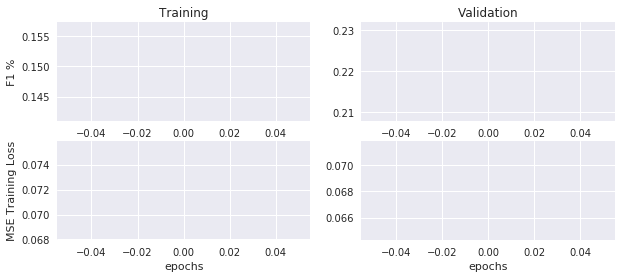

In [37]:
%matplotlib inline
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['f1'])

plt.ylabel('F1 %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_f1'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

After letting my code run on the genuse servers for 3 days, I learned I really need to clean up my data more and am out of time to continue this lab.